<a href="https://colab.research.google.com/github/Ge0f3/tensorflow_certification/blob/main/04_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Why use Transfer Learning ? 

*   Can leverage an existing neural network architecture proven to work on problems similar to our own 
*   Can Leverage a working network architecture which has already learned patterns on similar data to our own(often results in great results with less data)



## Feature extraction vs Fine-Tuning 

In **fine-tuning transfer learning** the pre-trained model weights from another model are unfrozen and tweaked during to better suit your own data.

For feature extraction transfer learning, you may only train the top 1-3 layers of a pre-trained model with your own data, in fine-tuning transfer learning, you might train 1-3+ layers of a pre-trained model (where the '+' indicates that many or all of the layers could be trained).

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/05-transfer-learning-feature-extraction-vs-fine-tuning.png)
*Feature extraction transfer learning vs. fine-tuning transfer learning. The main difference between the two is that in fine-tuning, more layers of the pre-trained model get unfrozen and tuned on custom data. This fine-tuning usually takes more data than feature extraction to be effective.*

In [ ]:
import tensorflow as tf

print(tf.__version__)

!nvidia-smi

2.8.2
Wed Aug 31 22:04:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-

### Getting the helper FN

In [ ]:
! wget https://raw.githubusercontent.com/Ge0f3/tensorflow_certification/main/helper_functions.py

--2022-08-31 22:04:21--  https://raw.githubusercontent.com/Ge0f3/tensorflow_certification/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10606 (10K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  10.36K  --.-KB/s    in 0s      

2022-08-31 22:04:21 (66.7 MB/s) - ‘helper_functions.py.2’ saved [10606/10606]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves,unzip_data, walk_through_dir



## Get Data

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

unzip_data('10_food_classes_10_percent.zip')

--2022-08-31 22:04:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.197.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.5’

10_food_classes_10_ 100%[===================>] 160.74M   149MB/s    in 1.1s    

2022-08-31 22:04:23 (149 MB/s) - ‘10_food_classes_10_percent.zip.5’ saved [168546183/168546183]



In [ ]:
walk_through_dir('10_food_classes_10_percent')

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [ ]:
train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

In [ ]:
#create data inputs 

IMG_SIZE = (224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir,
    image_size = IMG_SIZE,
    label_mode = 'categorical',
    batch_size = 32
)

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_dir,
    image_size = IMG_SIZE,
    label_mode = 'categorical'
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Check out the class name 

train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

### Model 0: Building a transfer learning model using the Keras Functional API

Alright, our data is tensor-ified, let's build a model.

To do so we're going to be using the [`tf.keras.applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications) module as it contains a series of already trained (on ImageNet) computer vision models as well as the Keras Functional API to construct our model.

We're going to go through the following steps:

1. Instantiate a pre-trained base model object by choosing a target model such as [`EfficientNetB0`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB0) from `tf.keras.applications`, setting the `include_top` parameter to `False` (we do this because we're going to create our own top, which are the output layers for the model).
2. Set the base model's `trainable` attribute to `False` to freeze all of the weights in the pre-trained model.
3. Define an input layer for our model, for example, what shape of data should our model expect?
4. [Optional] Normalize the inputs to our model if it requires. Some computer vision models such as `ResNetV250` require their inputs to be between 0 & 1. 

> 🤔 **Note:** As of writing, the `EfficientNet` models in the `tf.keras.applications` module do not require images to be normalized (pixel values between 0 and 1) on input, where as many of the other models do. I posted [an issue to the TensorFlow GitHub](https://github.com/tensorflow/tensorflow/issues/42506) about this and they confirmed this. 

5. Pass the inputs to the base model.
6. Pool the outputs of the base model into a shape compatible with the output activation layer (turn base model output tensors into same shape as label tensors). This can be done using [`tf.keras.layers.GlobalAveragePooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) or [`tf.keras.layers.GlobalMaxPooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool2D?hl=en) though the former is more common in practice.
7. Create an output activation layer using `tf.keras.layers.Dense()` with the appropriate activation function and number of neurons.
8. Combine the inputs and outputs layer into a model using [`tf.keras.Model()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model).
9. Compile the model using the appropriate loss function and choose of optimizer.
10. Fit the model for desired number of epochs and with necessary callbacks (in our case, we'll start off with the TensorBoard callback).

Woah... that sounds like a lot. Before we get ahead of ourselves, let's see it in practice.

In [ ]:
# Model_0 

# Create a base model 

base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# Free the base model 
base_model.trainable = False

#Create input layers 
inputs = tf.keras.layers.Input(shape=(224,224,3),name = 'Input Layer')

#pass the input to the base model
x = base_model(inputs)
print(f"The shape of the model : {x.shape}")

#Average pool the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name='Global_Average_Pooling')(x)

#Check the output activation Layer
outputs = tf.keras.layers.Dense(10,activation='softmax',name='output_layer')(x)

#Combine the inputs with the outputs into a model 
model_0 = tf.keras.Model(inputs,outputs)

#Compile model 
model_0.compile(
    loss='categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics =['accuracy']
)

#fit the model 
history_10_percent = model_0.fit(
    train_data_10_percent,
    epochs=5,
    steps_per_epoch = len(train_data_10_percent),
    validation_data = test_data_10_percent,
    validation_steps = int(0.25 * len(test_data_10_percent)),
    callbacks = [
        create_tensorboard_callback(
            'transfer_learning',
            '10_percent_feature_extract'
        )
    ]
)





The shape of the model : (None, 7, 7, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20220831-220434
Epoch 1/5
24/24 [==============================] - 17s 276ms/step - loss: 1.9342 - accuracy: 0.3920 - val_loss: 1.3831 - val_accuracy: 0.7039
Epoch 2/5
24/24 [==============================] - 4s 161ms/step - loss: 1.1677 - accuracy: 0.7293 - val_loss: 0.9732 - val_accuracy: 0.7664
Epoch 3/5
24/24 [==============================] - 5s 190ms/step - loss: 0.8402 - accuracy: 0.8027 - val_loss: 0.7696 - val_accuracy: 0.8059
Epoch 4/5
24/24 [==============================] - 4s 163ms/step - loss: 0.6893 - accuracy: 0.8347 - val_loss: 0.7022 - val_accuracy: 0.8059
Epoch 5/5
24/24 [==============================] - 5s 190ms/step - loss: 0.5961 - accuracy: 0.8560 - val_loss: 0.6136 - val_accuracy: 0.8257


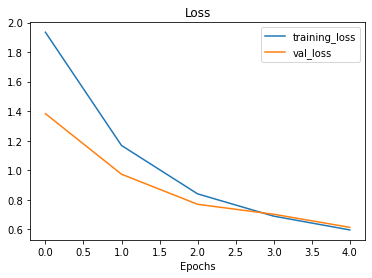

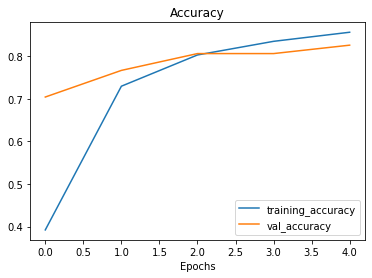

In [ ]:
plot_loss_curves(history_10_percent)

In [ ]:
# # Check layers in our base model
# for layer_number, layer in enumerate(base_model.layers):
#   print(layer_number, layer.name)

In [ ]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 Global_Average_Pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


## Getting a feature vector from a trained model

> 🤔 **Question:** What happens with the `tf.keras.layers.GlobalAveragePooling2D()` layer? I haven't seen it before.

The [`tf.keras.layers.GlobalAveragePooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) layer transforms a 4D tensor into a 2D tensor by averaging the values across the inner-axes.

The previous sentence is a bit of a mouthful, so let's see an example.

In [ ]:
# Define input tensor shape (same number of dimensions as the output of efficientnetb0)
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shapes of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


In [ ]:
# This is the same as GlobalAveragePooling2D()
tf.reduce_mean(input_tensor, axis=[1, 2]) # average across the middle axes

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

## Running a series of transfer learning experiments

We've seen the incredible results of transfer learning on 10% of the training data, what about 1% of the training data?

What kind of results do you think we can get using 100x less data than the original CNN models we built ourselves?

Why don't we answer that question while running the following modelling experiments:
1. `model_1`: Use feature extraction transfer learning on 1% of the training data with data augmentation.
2. `model_2`: Use feature extraction transfer learning on 10% of the training data with data augmentation.
3. `model_3`: Use fine-tuning transfer learning on 10% of the training data with data augmentation.
4. `model_4`: Use fine-tuning transfer learning on 100% of the training data with data augmentation.

While all of the experiments will be run on different versions of the training data, they will all be evaluated on the same test dataset, this ensures the results of each experiment are as comparable as possible.

All experiments will be done using the `EfficientNetB0` model within the `tf.keras.applications` module.

To make sure we're keeping track of our experiments, we'll use our `create_tensorboard_callback()` function to log all of the model training logs.

We'll construct each model using the Keras Functional API and instead of implementing data augmentation in the `ImageDataGenerator` class as we have previously, we're going to build it right into the model using the [`tf.keras.layers.experimental.preprocessing`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing) module.

Let's begin by downloading the data for experiment 1, using feature extraction transfer learning on 1% of the training data with data augmentation.

### model_1: Use feature extraction transfer learning on 1% of the training data with data augmentation.

In [ ]:
! wget  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip


--2022-08-31 22:05:12--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.128, 173.194.203.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.2’

10_food_classes_1_p 100%[===================>] 127.42M   119MB/s    in 1.1s    

2022-08-31 22:05:14 (119 MB/s) - ‘10_food_classes_1_percent.zip.2’ saved [133612354/133612354]



In [ ]:
#unzip the data
unzip_data('10_food_classes_1_percent.zip')

#Create training and testing dir 
train_dir_1_percent = '10_food_classes_1_percent/train/'
test_dir_1_percent = '10_food_classes_1_percent/test/'


In [ ]:
import tensorflow as tf

IMG_SIZE =(224,224)

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_1_percent,
    label_mode= 'categorical',
    batch_size=32,
    image_size = IMG_SIZE
)
test_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    image_size=IMG_SIZE
)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Adding data augmentation to the model layer

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

#Create a data agumentation 
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

### Visualize the data augmentation 

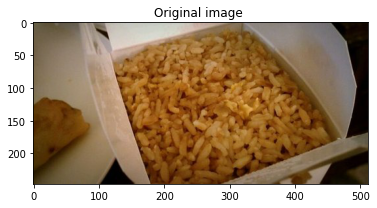

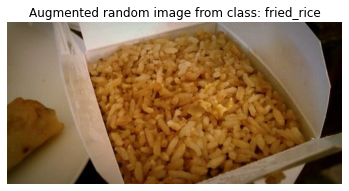

In [ ]:
from sys import meta_path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os 
import random 

target_class = random.choice(train_data_1_percent.class_names)
target_dir = '10_food_classes_1_percent/train/'+target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path =  target_dir+'/'+random_image



# Read the image 
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title("Original image ")

plt.imshow(img)
plt.title("Original image ")

augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);




### model_2: Use feature extraction transfer learning on 10% of the training data with data augmentation.


In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

--2022-08-31 22:05:16--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.128, 173.194.203.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.6’

10_food_classes_10_ 100%[===================>] 160.74M   151MB/s    in 1.1s    

2022-08-31 22:05:17 (151 MB/s) - ‘10_food_classes_10_percent.zip.6’ saved [168546183/168546183]



In [ ]:
train_dir_10_percent = '10_food_classes_10_percent/train/'
test_dir_10_percent = '10_food_classes_10_percent/test/'

In [ ]:
IMG_SIZE = (224,224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_10_percent,
    label_mode = 'categorical',
    image_size = IMG_SIZE
)

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir_10_percent,
    label_mode = 'categorical',
    image_size = IMG_SIZE
)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

#Build the data augmentation layer

data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2)
],name='data_augmentation')


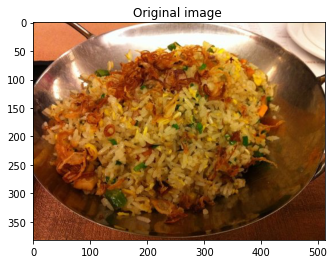

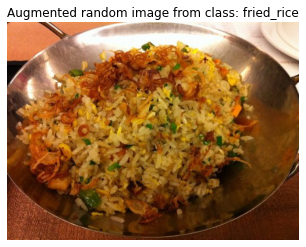

In [ ]:
from sys import meta_path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os 
import random 

target_class = random.choice(train_data_1_percent.class_names)
target_dir = '10_food_classes_1_percent/train/'+target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path =  target_dir+'/'+random_image



# Read the image 
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title("Original image ")

plt.imshow(img)
plt.title("Original image ")

augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

In [ ]:
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

#Create input layer
inputs = layers.Input(shape = input_shape,name='input_layer')

#Add a data augmentation 
x = data_augmentation(inputs)

#Give base model inputs 
x = base_model(x,training=False)

#pool output feature of the base model 
x = layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

outputs = layers.Dense(10,activation='softmax',name='output_layer')(x)

#Make a model with inputs and outputs
model_2 = keras.Model(inputs,outputs)

#compile the model 
model_2.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)



In [ ]:
# Create model check point 

checkpoint_path = 'ten_percent_model_checkpoints_weights/checkpoint.ckpt'

#Create a Model Checkpoint callback that saves the model's weights only 
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,
    save_weights_only = True,
    save_best_only = False,
    save_freq = 'epoch',
    verbose =1
)

### Fit Model 2 in the modelchecpoint callback 

In [ ]:
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data_10_percent,
                                          validation_steps=int(0.25 * len(test_data_10_percent)), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"), 
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220831-220523
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9999 - accuracy: 0.3307
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 22s 633ms/step - loss: 1.9999 - accuracy: 0.3307 - val_loss: 1.5278 - val_accuracy: 0.6283
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3572 - accuracy: 0.6840
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 12s 494ms/step - loss: 1.3572 - accuracy: 0.6840 - val_loss: 1.0992 - val_accuracy: 0.7368
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0627 - accuracy: 0.7387
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 10s 418ms/step - loss: 1.0627 - accuracy: 0.7387 - val_loss: 0.9134 - val_accuracy: 0.7780
E

In [ ]:
model_2.evaluate(test_data_10_percent)

79/79 [==============================] - 7s 83ms/step - loss: 0.6894 - accuracy: 0.8192


[0.6894263029098511, 0.8191999793052673]

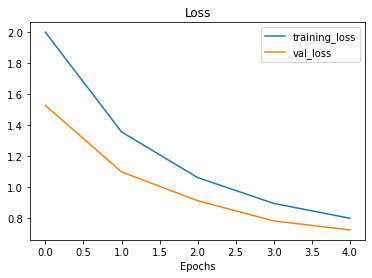

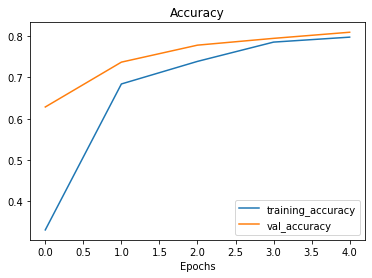

In [ ]:
plot_loss_curves(history_10_percent_data_aug)

### model_3: Use fine-tuning transfer learning on 10% of the training data with data augmentation.


In [ ]:
IMG_SIZE = (224,224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_10_percent,
    label_mode = 'categorical',
    image_size = IMG_SIZE
)

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir_10_percent,
    label_mode = 'categorical',
    image_size = IMG_SIZE
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
model_2.layers

In [ ]:
for layer in model_2.layers:
  print(layer.name,layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 False
global_average_pooling_layer True
output_layer True


In [ ]:
for i,layer in enumerate(model_2.layers[2].layers):
  print(i,layer.name,layer.trainable)

0 input_2 False
1 rescaling_1 False
2 normalization_1 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
print(len(model_2.layers[2].trainable_variables))

0


In [ ]:
#Setting the last 1- layers of our base_model.trainable = True

base_model.trainable = True

#Freeze all layers except for the last 10 
for layer in base_model.layers[:-10]:
  layer.trainable = False

#Recompile 
model_2.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(lr= 0.0001), # when finetuning lower the leraning rate by 10x
    metrics = ['accuracy']
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights_fine_tune/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=True, # set to True to save only the best model instead of a model every epoch 
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

In [ ]:
fine_tune_epochs = initial_epochs + 5


history_fine_10_percent_data_aug = model_2.fit(
    train_data_10_percent,
    epochs = fine_tune_epochs,
    validation_data = test_data_10_percent,
    initial_epoch=history_10_percent_data_aug.epoch[-1], # start from previous last epoch
    validation_steps = int(0.25 * len(test_data_10_percent)),
    callbacks = [create_tensorboard_callback("transfer_learning", "10_percent_data_aug_fine_tune"), 
                                                     checkpoint_callback]
)

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug_fine_tune/20220831-220648
Epoch 5/10
24/24 [==============================] - ETA: 0s - loss: 0.6626 - accuracy: 0.7973
Epoch 5: val_loss improved from inf to 0.53949, saving model to ten_percent_model_checkpoints_weights_fine_tune/checkpoint.ckpt
24/24 [==============================] - 20s 506ms/step - loss: 0.6626 - accuracy: 0.7973 - val_loss: 0.5395 - val_accuracy: 0.8388
Epoch 6/10
24/24 [==============================] - ETA: 0s - loss: 0.5537 - accuracy: 0.8347
Epoch 6: val_loss improved from 0.53949 to 0.50311, saving model to ten_percent_model_checkpoints_weights_fine_tune/checkpoint.ckpt
24/24 [==============================] - 9s 374ms/step - loss: 0.5537 - accuracy: 0.8347 - val_loss: 0.5031 - val_accuracy: 0.8421
Epoch 7/10
24/24 [==============================] - ETA: 0s - loss: 0.5017 - accuracy: 0.8600
Epoch 7: val_loss did not improve from 0.50311
24/24 [==============================] - 8s 308ms/s

In [ ]:
model_2.evaluate(test_data_10_percent)

79/79 [==============================] - 7s 78ms/step - loss: 0.4977 - accuracy: 0.8396


[0.4977324306964874, 0.8396000266075134]

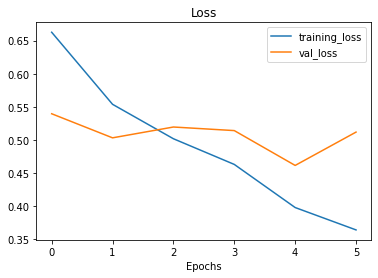

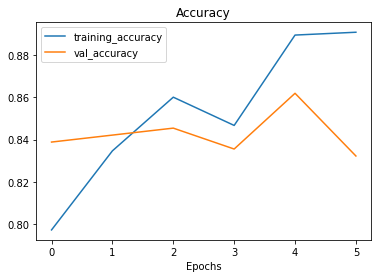

In [ ]:
plot_loss_curves(history_fine_10_percent_data_aug)

In [ ]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.3306666612625122, 0.6840000152587891, 0.7386666536331177, 0.7853333353996277, 0.7973333597183228, 0.7973333597183228, 0.8346666693687439, 0.8600000143051147, 0.846666693687439, 0.8893333077430725, 0.890666663646698]


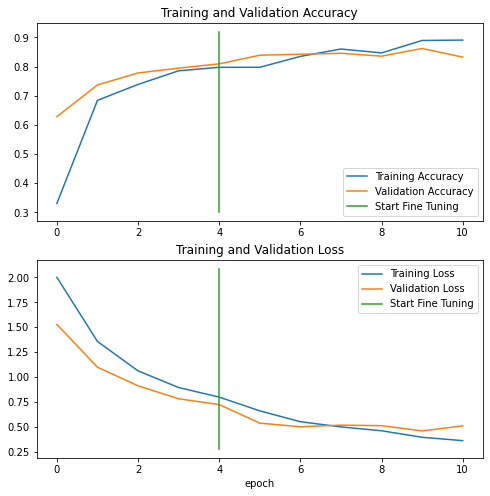

In [ ]:
compare_historys(
    original_history=history_10_percent_data_aug,
    new_history = history_fine_10_percent_data_aug,
    initial_epochs=5
)

### model_4: Use fine-tuning transfer learning on 100% of the training data with data augmentation.

In [ ]:
# Download and unzip 10 classes of data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 
unzip_data("10_food_classes_all_data.zip")

# Setup data directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"


--2022-08-31 22:08:15--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 172.253.117.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.2’

10_food_classes_all 100%[===================>] 495.13M  77.0MB/s    in 7.1s    

2022-08-31 22:08:22 (70.1 MB/s) - ‘10_food_classes_all_data.zip.2’ saved [519183241/519183241]



In [ ]:
import tensorflow as tf 

IMG_SIZE = (224,224)

train_data_full = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode = 'categorical',
    image_size = IMG_SIZE
)

test_data_full = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode = 'categorical',
    image_size = IMG_SIZE
)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Evaluate model (this is the fine-tuned 10 percent of data version)
model_2.evaluate(test_data_full)

79/79 [==============================] - 7s 79ms/step - loss: 0.4977 - accuracy: 0.8396


[0.4977322220802307, 0.8396000266075134]

In [ ]:
model_2.load_weights(checkpoint_path)

In [ ]:
# Evaluate model again 
model_2.evaluate(test_data_full)

79/79 [==============================] - 7s 79ms/step - loss: 0.5020 - accuracy: 0.8348


[0.5020159482955933, 0.8348000049591064]

In [ ]:
for layer_num, layer in enumerate(model_2.layers):
  print(layer_num,layer.name,layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 output_layer True


In [ ]:
for layer_num, layer in enumerate(model_2.layers[2].layers):
  print(layer_num,layer.name,layer.trainable)

0 input_2 False
1 rescaling_1 False
2 normalization_1 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001), # divide learning rate by 10 for fine-tuning
                metrics=["accuracy"])

In [ ]:
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_full,
                                           epochs=fine_tune_epochs,
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           validation_data=test_data_full,
                                           validation_steps=int(0.25 * len(test_data_full)),
                                           callbacks = [create_tensorboard_callback("transfer_learning", "10_percent_data_aug_fine_tune_full")
                                                     ]
                                           )

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug_fine_tune_full/20220831-220849
Epoch 5/10
235/235 [==============================] - 62s 231ms/step - loss: 0.6916 - accuracy: 0.7755 - val_loss: 0.4453 - val_accuracy: 0.8586
Epoch 6/10
235/235 [==============================] - 50s 213ms/step - loss: 0.5701 - accuracy: 0.8197 - val_loss: 0.3825 - val_accuracy: 0.8783
Epoch 7/10
235/235 [==============================] - 45s 189ms/step - loss: 0.5171 - accuracy: 0.8328 - val_loss: 0.3827 - val_accuracy: 0.8766
Epoch 8/10
235/235 [==============================] - 43s 180ms/step - loss: 0.4699 - accuracy: 0.8523 - val_loss: 0.3570 - val_accuracy: 0.8816
Epoch 9/10
235/235 [==============================] - 41s 172ms/step - loss: 0.4459 - accuracy: 0.8585 - val_loss: 0.3145 - val_accuracy: 0.8947
Epoch 10/10
235/235 [==============================] - 38s 158ms/step - loss: 0.4099 - accuracy: 0.8700 - val_loss: 0.3028 - val_accuracy: 0.8980


In [ ]:
model_2.evaluate(test_data_full)

79/79 [==============================] - 10s 113ms/step - loss: 0.3101 - accuracy: 0.9016


[0.3101479411125183, 0.9016000032424927]

5
11
[0.3306666612625122, 0.6840000152587891, 0.7386666536331177, 0.7853333353996277, 0.7973333597183228, 0.7754666805267334, 0.8197333216667175, 0.8327999711036682, 0.8522666692733765, 0.8585333228111267, 0.8700000047683716]


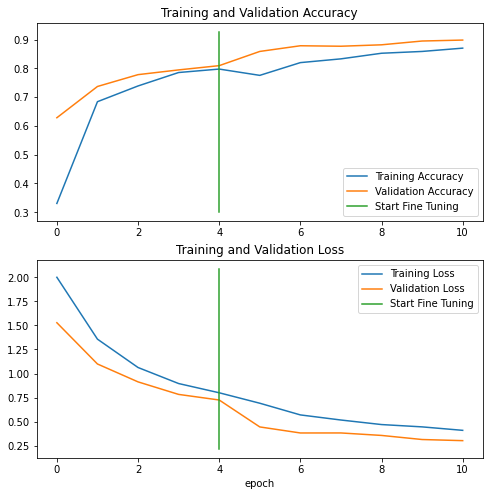

In [ ]:
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)


In [ ]:
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer learning experiments" \
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" \
  --one_shot # exits the uploader when upload has finished


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=jHySDIbqX8Hv8RFCcJfxt3i3WCUllf&prompt=consent&access_type=o